## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import wandb
from torchvision import models
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt

os.chdir('/opt/ml')
from utils.Dataset import Class18Dataset, cfg, get_img_paths, Class18Dataset_Crops
from utils.utils import calculate_norm, linear_param_initialize, train_mean_std
import torch.utils.data as data
from tqdm.notebook import tqdm
from train import train
from baseline.loss import FocalLoss, LabelSmoothingLoss, F1Loss
import warnings
from model.model import ThreeOneNet
from utils.utils import eval_mean_std
from baseline.dataset_mike import MaskBaseDataset, MyCrop, MyCropDown, MyCropMid
warnings.filterwarnings('ignore')

In [2]:
idx = 820

# 원본 이미지

In [3]:
#transform
train_transformer=transforms.Compose([
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(3),
                   ])

# val_transformer=transforms.Compose([
#                     MyCrop(),
#                     transforms.Resize((370,324),Image.BILINEAR),
#                     transforms.ToTensor(),
#                     transforms.Grayscale(3),
#                     transforms.RandomAutocontrast(p=1)
#                     ])

In [4]:
original_train_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=train_transformer, mode='train', val_ratio=0.2)

/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg


In [5]:
original_train_dataset[idx][0].permute(1,2,0).numpy().shape

(355, 324, 3)

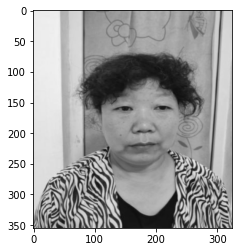

In [6]:
img1 = original_train_dataset[idx][0].permute(1,2,0).numpy()
plt.imshow(original_train_dataset[idx][0].permute(1,2,0).numpy())

# Mycrop + random + resize

In [7]:
train_transformer=transforms.Compose([
                   MyCrop(),
                   transforms.RandomApply([transforms.RandomCrop((355,324))],p=1),
                  transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(3),
                   ])

In [8]:
MyCrop_train_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=train_transformer, mode='train', val_ratio=0.2)

/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg


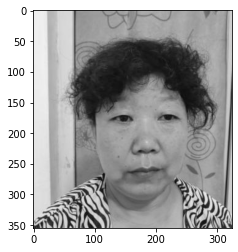

In [9]:
img2 = MyCrop_train_dataset[idx][0].permute(1,2,0).numpy()
plt.imshow(MyCrop_train_dataset[idx][0].permute(1,2,0).numpy())

# MycropMid + Resize

In [10]:
train_transformer=transforms.Compose([
                   MyCropMid(),
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(3),
                   ])

In [11]:
MyCropMid_train_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=train_transformer, mode='train', val_ratio=0.2)

/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg


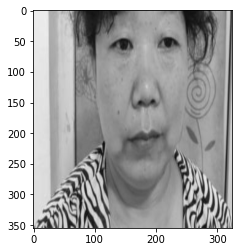

In [12]:
img3 = MyCropMid_train_dataset[idx][0].permute(1,2,0).numpy()
plt.imshow(MyCropMid_train_dataset[idx][0].permute(1,2,0).numpy())

# MycropDown + Resize

In [13]:
train_transformer=transforms.Compose([
                   MyCropDown(),
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(3),
                   ])

In [14]:
MycropDown_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=train_transformer, mode='train', val_ratio=0.2)

/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg


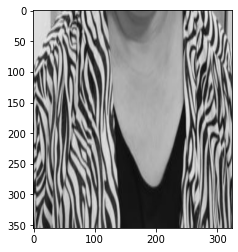

In [15]:
img4 = MycropDown_dataset[idx][0].permute(1,2,0).numpy()
plt.imshow(MycropDown_dataset[idx][0].permute(1,2,0).numpy())

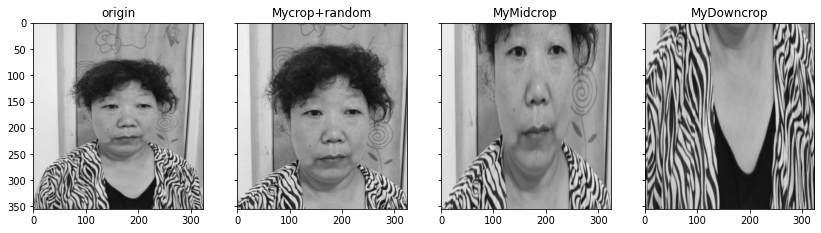

In [16]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 8))

name = ['origin', 'Mycrop+random', 'MyMidcrop', 'MyDowncrop']
imgs = [img1,img2,img3,img4]

for idx, (name,img) in enumerate(zip(name,imgs)):
    axes[idx].imshow(img)
    axes[idx].set_title(name)
plt.show()

# 3개 채널 합치기

In [17]:
Mycrop_transformer=transforms.Compose([
                   MyCrop(),
                   transforms.RandomApply([transforms.RandomCrop((355,324))],p=1),
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(1),
                   ])

MycropMid_transformer=transforms.Compose([
                   MyCropMid(),
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(1),
                   ])

MycropDown_transformer=transforms.Compose([
                   MyCropDown(),
                   transforms.Resize((355,324),Image.BILINEAR),
                   transforms.ToTensor(),
                   transforms.Grayscale(1),
                   ])

In [18]:
MyCrop_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=Mycrop_transformer, mode='train', val_ratio=0.2)
MyCropMid_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=MycropMid_transformer, mode='train', val_ratio=0.2)
MyCropDown_dataset = MaskBaseDataset('/opt/ml/data/train/images', transform=MycropDown_transformer, mode='train', val_ratio=0.2)

/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg
/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg
/opt/ml/data/train/images/000265_female_Asian_58/mask3.jpg


In [19]:
img1 = MyCrop_dataset[0][0]
img2 = MyCropMid_dataset[0][0]
img3 = MyCropDown_dataset[0][0]

In [20]:
img = torch.cat([img1,img2,img3],dim=0)

In [21]:
img.shape

torch.Size([3, 355, 324])

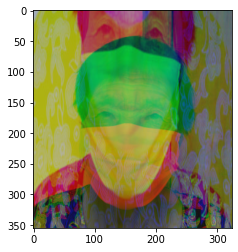

In [22]:
plt.imshow(img.permute(1,2,0).numpy())

In [23]:
img_paths = get_img_paths(cfg)
test = Class18Dataset_Crops(img_paths, cfg, transform1=Mycrop_transformer, transform2=MycropMid_transformer, transform3=MycropDown_transformer)

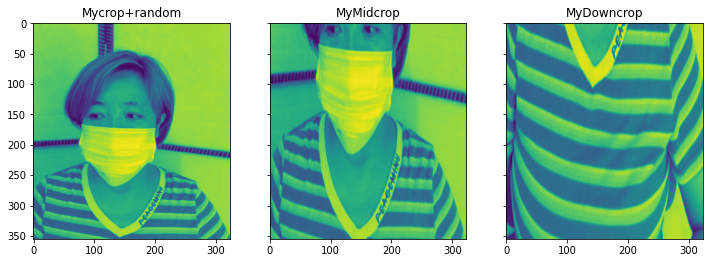

In [32]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))

name = ['Mycrop+random', 'MyMidcrop', 'MyDowncrop']
imgs = [test[0][0][0],test[0][0][1],test[0][0][2]]

for idx, (name,img) in enumerate(zip(name,imgs)):
    axes[idx].imshow(img)
    axes[idx].set_title(name)
plt.show()